In [1]:
import pandas as pd
import numpy as np
import axelrod as axl
import pathlib 

In [2]:
df = pd.read_csv("outcomes.csv", header=None)
df.columns = ["strategy 1", "strategy 2", "score 1", "score 2", "count"]

In [3]:
df.describe()

,score 1,score 2,count
count,2.305486e+06,2.305486e+06,2.305486e+06
mean,2.179908e+00,2.278338e+00,1.910012e+01
std,7.342048e-01,8.566840e-01,2.463772e+02
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.705000e+00,1.635000e+00,1.000000e+00
50%,2.155000e+00,2.305000e+00,2.000000e+00
75%,2.595000e+00,2.885000e+00,7.000000e+00
max,5.000000e+00,5.000000e+00,1.000000e+04


Creating a dictionary `f` that maps a name of strategy tuples to the mean utility for that matchup:


In [4]:
utilities = {pair: (f["score 1"].mean(), f["score 2"].mean()) 
             for pair, f in df.groupby(["strategy 1", "strategy 2"])}

In [5]:
def scores(strategy_pair, utilities=utilities):
    """
    Return the fitness scores:
    
        [a, b]
        [c, d]
    
    for a pair of strategies, in a population of N individuals 
    with i individuals of the first type.
    """
    try:
        s1, s2 = strategy_pair
        scores = np.array([[utilities[(s1, s1)][0], utilities[(s1, s2)][0]], 
                           [utilities[(s1, s2)][1], utilities[(s2, s2)][0]]])
    except KeyError:
        s2, s1 = strategy_pair
        scores = np.array([[utilities[(s2, s2)][0], utilities[(s1, s2)][1]], 
                           [utilities[(s1, s2)][0], utilities[(s1, s1)][0]]])
    return scores

In [6]:
scores(("Alternator", "Tit For Tat"))

array([[ 2.   ,  2.515],
       [ 2.49 ,  3.   ]])

In [7]:
def fitness(strategy_pair, N, i, utilities=utilities):
    """
    Return the fitness of a strategy pair in a population with 
    N total individuals and i individuals of the first type.
    """
    m = scores(strategy_pair, utilities)    
    return np.dot(m, np.array([i, N - i]))

In [8]:
# Compute fitness for case of Alternator invading population of Cooperators
fitness(("Alternator", "Tit For Tat"), 5, 1)

array([ 12.06,  14.49])

In [9]:
fitness(("Cooperator", "Tit For Tat"), 5, 1)

array([ 15.,  15.])

In [10]:
def transition(strategy_pair, N, i, utilities=utilities):
    """
    Return the 3 transition probabilities:
    
    P[i, i - 1]
    P[i, i]
    P[i, i + 1]
    
    Assuming: 
     - a given stratgy pair, 
     - a given total population size N
     - and a state i (the number of individuals of the first type)
    """
    fit = fitness(strategy_pair, N, i, utilities=utilities)
    p_up = (fit[0] * i / (fit[0] * i + fit[1] * (N - i))) * (N - i) / N
    p_down = (fit[1] * (N - i) / (fit[0] * i + fit[1] * (N - i))) * (i) / N
    p_stay = 1 - p_up - p_down
    return p_down, p_stay, p_up

In [11]:
# Compute transitions probabilitis for the case of Alternator invading population of Cooperators
transition(("Alternator", "Tit For Tat"), 5, 1)

(0.16555269922879179, 0.69665809768637532, 0.13778920308483292)

In [12]:
transition(("Cooperator", "Tit For Tat"), 5, 1)

(0.16, 0.67999999999999994, 0.16)

In [13]:
# Using Marc's code with a modification 
# (just so that it fits with what I've 
# done so far but not precious about this)

def fixation(strategy_pair, N, i=1, utilities=utilities):
    """Return the fixation probability for each pair"""
    ratios = []
    for j in range(1, N): # ignore first and last transitions, which are likely zero
        p_down, _, p_up = transition(strategy_pair, N, j, utilities=utilities)
        ratios.append(p_down / p_up)
    t = np.cumprod(ratios)
    s = np.cumsum(t)
    if i > 1:
        return (1 + s[i - 2]) / (1 + s[-1])
    return 1 / (1 + s[-1])

In [14]:
# Confirm that the calculation works with i != 1.
fixation(("Alternator", "Tit For Tat"), 5), 1 - fixation(("Tit For Tat", "Alternator"), 5, i=4)

(0.13118133280009905, 0.13118133280009903)

In [15]:
# Confirm that the calculation works with i != 1.
fixation(("Alternator", "Tit For Tat"), 5), 1 - fixation(("Tit For Tat", "Alternator"), 5, i=4)

(0.13118133280009905, 0.13118133280009903)

In [23]:
def write_fixation(N):
    """
    Write fixation probabilities for all 
    strategy pairs to a file called 'results/fixation_N.csv'
    
    File looks like:
    
    s1, s2, x_1, x_{N - 1}
    """
    path = pathlib.Path("results")
    path.mkdir(exist_ok=True)
    path = pathlib.Path("results") / "fixation_{}.csv".format(N)

    with path.open("w") as textfile:
        for strategy_pair in utilities:
            if strategy_pair[0] != strategy_pair[1]:
                fixation_probabilities = fixation(strategy_pair, N), fixation(strategy_pair, N, N - 1)
                textfile.write("{}, {}, {}, {}\n".format(*strategy_pair, *fixation_probabilities))

In [24]:
# Write all of these to file
for N in range(2, 12 + 1):
    write_fixation(N)

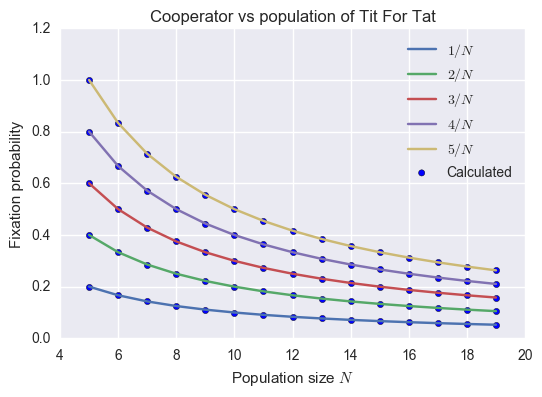

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
ns = range(5, 20)
plt.figure()
for i in range(1, min(ns) + 1):
    theoretic = [i / n for n in ns]
    calculated = [fixation(("Cooperator", "Tit For Tat"), n, i) for n in ns]
    plt.plot(ns, theoretic, label="${}/N$".format(i))
    plt.title("Cooperator vs population of Tit For Tat")
    if i == min(ns):
        plt.scatter(ns, calculated, label="Calculated")
    else:
        plt.scatter(ns, calculated)

    plt.xlabel("Population size $N$")
    plt.ylabel("Fixation probability")
    plt.legend();

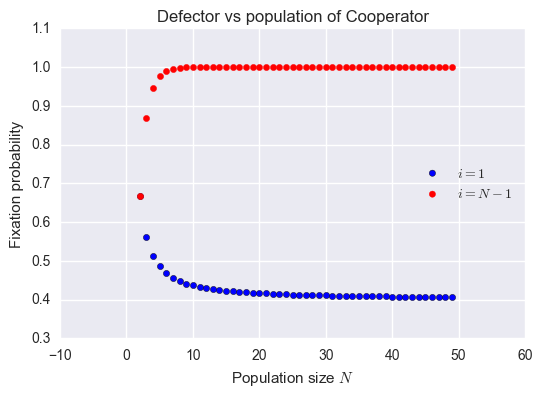

In [28]:
plt.figure()

strategies = ("Defector", "Cooperator")
ns = range(2, 50)
invader = [fixation(strategies, n) for n in ns]   
resistor = [fixation(strategies, n, n - 1) for n in ns] 
plt.title("{} vs population of {}".format(*strategies))
plt.scatter(ns, invader, label="$i=1$")
plt.scatter(ns, resistor, color="red", label="$i=N-1$")

plt.xlabel("Population size $N$")
plt.ylabel("Fixation probability")
plt.legend(loc=5);

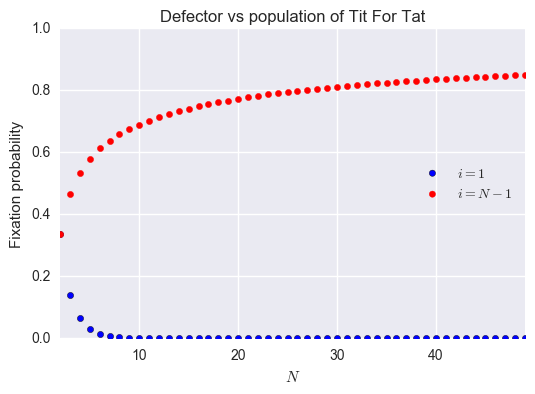

In [30]:
plt.figure()


strategies = ("Defector", "Tit For Tat")
ns = range(2, 50)
invader = [fixation(strategies, n) for n in ns]   
resistor = [fixation(strategies, n, n - 1) for n in ns] 
plt.title("{} vs population of {}".format(*strategies))
plt.scatter(ns, invader, label="$i=1$")
plt.scatter(ns, resistor, color="red", label="$i=N-1$")

plt.xlabel("$N$")
plt.ylabel("Fixation probability")
plt.ylim(0, 1)
plt.xlim(min(ns), max(ns))
plt.legend(loc=5);